In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time

from emd import emd
from kde.location_project.cmp import geodesic_dist
# from kde.location_project.kde_2d import kdnearest

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
time_span = 'month'
n_visits = 20

# Geolocation Data - Twitter

NOTE: all of the results in the paper discussed B as fixed, but in this analysis A is fixed.

## Descriptive Statistics 

In [2]:
### OC
oc_directory = os.path.join("..", "data", "oc") 
oc = pd.read_csv(os.path.join(oc_directory, "visits_no_filter.csv"))
oc_deduped = pd.read_csv(os.path.join(oc_directory, "visits_deduped.csv"))
oc_mpp = pd.read_csv(os.path.join(oc_directory, "mpp_visits_month0a_month1b_n20.csv"))

print("Days:", oc['day_id'].nunique())
print("Accounts:", oc['user_id'].nunique())
print("Events: ", oc.shape[0], " (", round(oc.shape[0] / oc['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", oc_deduped.shape[0], " (", round(oc_deduped.shape[0] / oc['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", oc_mpp['uid'].nunique())
print("Visits: ", len(oc_mpp), " (", round(len(oc_mpp) / oc_mpp['uid'].nunique(), 1), ")",sep="")

Days: 240
Accounts: 103271
Events: 655917 (6.4)
Visits: 545697 (5.3)

MPP DATA (at least 20 visits in each of the first two months)
Users: 223
Visits: 28052 (125.8)


In [3]:
### NY
ny_directory = os.path.join("..", "data", "ny") 
ny = pd.read_csv(os.path.join(ny_directory, "visits_no_filter.csv"))
ny_deduped = pd.read_csv(os.path.join(ny_directory, "visits_deduped.csv"))
ny_mpp = pd.read_csv(os.path.join(ny_directory, "mpp_visits_month0a_month1b_n20.csv"))

print("Days:", ny['day_id'].nunique())
print("Accounts:", ny['user_id'].nunique())
print("Events: ", ny.shape[0], " (", round(ny.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", ny_deduped.shape[0], " (", round(ny_deduped.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", ny_mpp['uid'].nunique())
print("Visits: ", len(ny_mpp), " (", round(len(ny_mpp) / ny_mpp['uid'].nunique(), 1), ")",sep="")

Days: 239
Accounts: 194224
Events: 1162871 (6.0)
Visits: 989494 (5.1)

MPP DATA (at least 20 visits in each of the first two months)
Users: 184
Visits: 22936 (124.7)


## Example Plots

In [4]:
def calc_freqs(df):
    ### grid the population data for OC & count visits in each bin
    data = df.copy()
    data["lat_r"] = data.lat.round(3)
    data["lon_r"] = data.lon.round(3)
    freqs = (
        data.groupby(["lat_r", "lon_r"]).count().reset_index()[["lat_r", "lon_r", "event_id"]]
    )
    freqs.columns = ["lat_r", "lon_r", "freq"]
    return freqs


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def make_user_scatter_plot(mpp, uid, mark):
    user = get_user(mpp, uid, mark)
    return list(zip(user.lat, user.lon))

In [5]:
import branca.colormap as cm
from branca.element import Template, MacroElement
from collections import defaultdict
import folium
from folium.plugins import HeatMap, MarkerCluster


### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>Month 1</li>
    <li><span style='background:red;'></span>Month 2</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


def plot_heat_and_scatter(freqs, mpp, uid, loc, uidB=None, heat=True):
    if uidB is None:
        uidB = uid
    if heat:
        col = 'lightgreen'
        opacity = 0.8
    else:
        col = 'red'
        opacity = 0.75
    
    ### make the map
    if loc == 'oc':
        hmap = folium.Map(
            location=[33.68, -117.78],
            width='70%', 
            # width='60%',
            # height='95%',
            zoom_start=10, 
            zoom_control=False,
            tiles='CartoDB positron',
        )
    elif loc =='ny':
        hmap = folium.Map(
            location=[40.735, -73.99],
            width='70%', 
            # width='60%',
            # height='95%',
#             zoom_start=12.5,
            zoom_start=11,
            zoom_control=False,
            tiles='CartoDB positron',
        )
    
    ### make the heatmap
    if heat:
        steps = 20
        color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)

        gradient_map = defaultdict(dict)
        for i in range(steps):
            gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

        if loc == 'oc':
            heat = HeatMap( 
                data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
                min_opacity=0.2,
                max_val=float(freqs['freq'].max()),
                radius=20, 
                blur=15, 
                max_zoom=5, 
                gradient=gradient_map
            )
        
        if loc == 'ny':
            heat = HeatMap( 
                data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
                min_opacity=0.2,
                max_val=float(freqs['freq'].max()),
                radius=20, 
                blur=15, 
                max_zoom=5, 
                gradient=gradient_map
            )
        
        hmap.add_child(heat)
        hmap.add_child(color_map)

    ### make the scatters
    f = folium.map.FeatureGroup()
    for pt in make_user_scatter_plot(mpp, uid, 'a'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color='black',
                fill_opacity=0.75)
        )

    for pt in make_user_scatter_plot(mpp, uidB, 'b'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color=col,
                fill_opacity=opacity)
        )
    hmap.add_child(f)

    ### add legend
    macro = MacroElement()
    macro._template = Template(template)
    hmap.get_root().add_child(macro)

    return hmap

In [6]:
oc_freqs = calc_freqs(oc_deduped)
plot_heat_and_scatter(freqs=oc_freqs, mpp=oc_mpp, uid=1, loc='oc')

In [7]:
ny_freqs = calc_freqs(ny_deduped)
plot_heat_and_scatter(freqs=ny_freqs, mpp=ny_mpp, uid=3, loc='ny', heat=False)

# Land Parcel Data


All my datasets sit at: `/extra/mlichman0/all_data/`

The Twitter one is in: `/extra/mlichman0/all_data/event_data/twitter/`

There are two types of location assignment, parcel and grid. Both are in that folder. If we take the parcel assignment file for the Orange Country for example, it's in: `/extra/mlichman0/all_data/event_data/twitter/parcel_ass/oc/area_assigned.csv`

There's also a filtered version of it with minimum 5 days for users and 3 events per locations in that folder.

The format is:

`[event_id, user_id, location_id, lon, lat, epoch time, day_id, seconds_since_monday]`

You can probably ignore some of those :)

You should have access, so let me know if you don't and I'll fix it.

## Descriptive Stats

#### OC

In [8]:
oc_locs = oc_deduped.groupby('location_id')['event_id'].count()
oc_locs.describe()

count    32978.000000
mean        16.547304
std        448.090031
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      72290.000000
Name: event_id, dtype: float64

In [9]:
oc_locs_users = oc_deduped.groupby(['location_id'])['old_uid'].nunique()
oc_locs_users.describe()

count    32978.000000
mean         7.852204
std        198.567716
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      30874.000000
Name: old_uid, dtype: float64

#### NY

In [10]:
ny_locs = ny_deduped.groupby('location_id')['event_id'].count()
ny_locs.describe()

count    21312.000000
mean        46.428960
std        698.078537
min          1.000000
25%          1.000000
50%          4.000000
75%         16.000000
max      75760.000000
Name: event_id, dtype: float64

In [11]:
ny_locs_users = ny_deduped.groupby(['location_id'])['old_uid'].nunique()
ny_locs_users.describe()

count    21312.000000
mean        26.827140
std        319.935058
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max      25775.000000
Name: old_uid, dtype: float64

## Plots

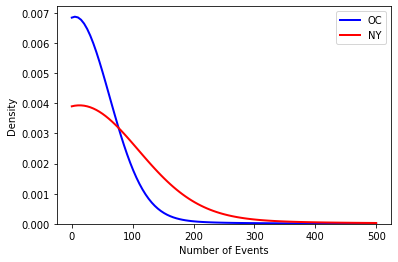

In [12]:
ax = sns.kdeplot(
    oc_locs, 
    color = 'blue',
    lw=2,
    clip=(0,500),
    label='OC'
)
ax = sns.kdeplot(
    ny_locs, 
    color = 'red',
    lw=2,
    clip=(0,500),
    label='NY'
)
ax.set(ylabel="Density")
ax.set(xlabel="Number of Events")
plt.show()

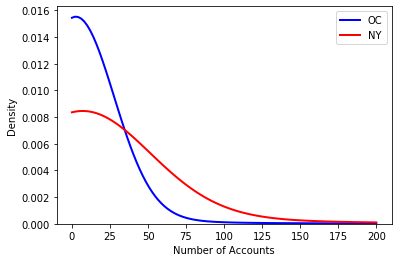

In [13]:
ax = sns.kdeplot(
    oc_locs_users, 
    color = 'blue',
    lw=2,
    clip=(0,200),
    label='OC'
)
ax = sns.kdeplot(
    ny_locs_users, 
    color = 'red',
    lw=2,
    clip=(0,200),
    label='NY'
)
ax.set(ylabel="Density")
ax.set(xlabel="Number of Accounts")
plt.show()

# Population Experiments - No Resampling

In [14]:
def population_scores(mpp):
    users = sorted(mpp['uid'].unique())  
    rslt = []
    
    for user_A in users[:2]:
        for user_B in users[:2]:
            tmp = {}
            try:
                ### get the data for the pair in question
                tmp['a'] = user_A
                tmp['b'] = user_B
                uA = get_user(mpp, user_A, 'a')
                uB = get_user(mpp, user_B, 'b')

                ### compute weights
                uA_wt_e = (uA['weight_event'] / sum(uA['weight_event'])).to_numpy()
                uA_wt_u = (uA['weight_user'] / sum(uA['weight_user'])).to_numpy()
                uB_wt_e = (uB['weight_event'] / sum(uB['weight_event'])).to_numpy()
                uB_wt_u = (uB['weight_user'] / sum(uB['weight_user'])).to_numpy()

                ### compute the distance matrix & IED scores
                dist = geodesic_dist(uA[['lat', 'lon']], uB[['lat', 'lon']])
                ied = dist.min(1)
                tmp['ied_med'] = np.median(ied)
                tmp['ied_mn'] = np.average(ied)
                tmp['ied_mn_wt_event'] = np.average(ied, weights=uA_wt_e)
                tmp['ied_mn_wt_user'] = np.average(ied, weights=uA_wt_u)

                ### compute variants of EMD
                tmp['emd'] = emd(distance="precomputed", D=dist)
                tmp['emd_wt_event'] = emd(
                    X_weights=uA_wt_e, Y_weights=uB_wt_e, distance="precomputed", D=dist
                )
                tmp['emd_wt_user'] = emd(
                    X_weights=uA_wt_u, Y_weights=uB_wt_u, distance="precomputed", D=dist
                )

                ### store it
                rslt.append(tmp)
            except:
                print(f"Error! A = {user_A}, B = {user_B}")
                continue
    
    return rslt

## OC
### Testing

In [15]:
# location weights based on number of visits
oc_wt_e = pd.DataFrame(oc_locs).reset_index().rename(columns={'event_id': 'weight'})
oc_wt_e['weight'] = 1 / oc_wt_e['weight']

# location weights based on number of unique users at location
oc_wt_u = pd.DataFrame(oc_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
oc_wt_u['weight'] = 1 / oc_wt_u['weight']

# merge weights in to the point pattern data
oc_mpp = pd.merge(oc_mpp, oc_wt_e, on='location_id')
oc_mpp = pd.merge(oc_mpp, oc_wt_u, on='location_id', suffixes=('_event', '_user'))
oc_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,2554741.0,1,a,-117.83335,33.74851,546927.0,0.008264,0.011905
1,67150220.0,60,a,-117.83335,33.74851,546927.0,0.008264,0.011905
2,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000
3,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000
4,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000


In [16]:
### perform the experiment
start = time.time()
oc_rslt = population_scores(oc_mpp)
end = time.time()
print("Elapsed time:", end - start, "s")

Elapsed time: 1.030547857284546 s


### Result

In [65]:
oc_rslt = pd.read_csv(os.path.join(oc_directory, "population_score_func_vals.csv"))
oc_rslt.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,1,1,0.154327,1.109798,0.899208,0.405424,5.203970,4.480238,8.447241
1,1,2,19.399004,16.106065,14.226849,16.525475,26.537134,25.318528,31.016127
2,1,3,31.568979,25.179988,22.962231,28.489488,27.707953,24.773531,30.671102
3,1,4,23.133342,20.379347,19.991566,23.394986,28.031713,31.332737,37.205909
4,1,5,3.722272,4.592512,5.569412,4.784752,12.625797,12.583956,13.965850


## NY

### Testing

In [18]:
# location weights based on number of visits
ny_wt_e = pd.DataFrame(ny_locs).reset_index().rename(columns={'event_id': 'weight'})
ny_wt_e['weight'] = 1 / ny_wt_e['weight']

# location weights based on number of unique users at location
ny_wt_u = pd.DataFrame(ny_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
ny_wt_u['weight'] = 1 / ny_wt_u['weight']

# merge weights in to the point pattern data
ny_mpp = pd.merge(ny_mpp, ny_wt_e, on='location_id')
ny_mpp = pd.merge(ny_mpp, ny_wt_u, on='location_id', suffixes=('_event', '_user'))
ny_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,420363.0,1,a,-74.00633,40.74349,25195.0,0.007194,0.022222
1,420363.0,1,a,-74.00625,40.74340,25195.0,0.007194,0.022222
2,420363.0,1,a,-74.00628,40.74371,25195.0,0.007194,0.022222
3,420363.0,1,a,-74.00617,40.74344,25195.0,0.007194,0.022222
4,420363.0,1,a,-74.00628,40.74371,25195.0,0.007194,0.022222


In [19]:
### perform the experiment
start = time.time()
ny_rslt = population_scores(ny_mpp)
end = time.time()
print("Elapsed time:", end - start, "s")

Elapsed time: 5.947452068328857 s


### Result

In [20]:
ny_rslt = pd.read_csv(os.path.join(ny_directory, "population_score_func_vals.csv"))
ny_rslt['same'] = (ny_rslt.a == ny_rslt.b).astype(bool)
ny_rslt.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,same
0,1,1,0.001110,0.057273,0.014944,0.007849,0.287525,0.179108,0.138875,True
1,1,2,2.615277,2.477955,2.467687,2.472530,6.588229,6.636982,6.576339,False
2,1,3,0.854050,0.802946,0.786963,0.791255,2.517792,2.530659,2.532609,False
3,1,4,0.160023,0.168516,0.079868,0.065438,3.156529,2.233205,2.184495,False
4,1,5,3.260494,3.390616,3.442907,3.448753,3.390616,3.442907,3.448753,False


In [21]:
ny_same = ny_rslt.loc[ny_rslt.a == ny_rslt.b, ]
ny_diff = ny_rslt.loc[ny_rslt.a != ny_rslt.b, ]


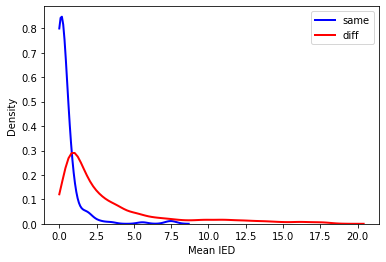

In [22]:
var = 'ied_mn_wt_event'
ax = sns.kdeplot(
    ny_same[var], 
    color = 'blue',
    lw=2,
    clip=(0,30),
    label='same'
)
ax = sns.kdeplot(
    ny_diff[var], 
    color = 'red',
    lw=2,
    clip=(0,30),
    label='diff'
)
ax.set(ylabel="Density")
ax.set(xlabel="Mean IED")
plt.show()

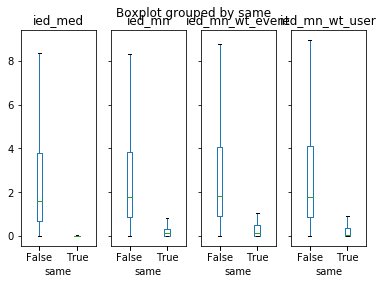

In [23]:
ny_rslt.boxplot(
    column=['ied_med', 'ied_mn', 'ied_mn_wt_event', 'ied_mn_wt_user'],
    layout=(1,4),
    by='same',
    grid=False,
    sym=''
)
plt.show()

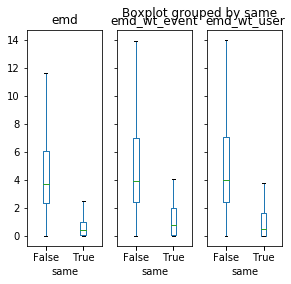

In [24]:
ny_rslt.boxplot(
    column=['emd', 'emd_wt_event', 'emd_wt_user'],
    layout=(1,4),
    by='same',
    grid=False,
    sym=''
)
plt.show()

# Evaluate the strength of evidence

### Test

In [25]:
from scipy import stats

def calc_slr(df, uA, uB, score):
    val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    same = df.loc[
        (df.a == df.b) & ~(df.a.isin({uA, uB})), 
        score
    ].to_numpy()
    diff = df.loc[
        (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), 
        score
    ].to_numpy()
    
    kde_same = stats.gaussian_kde(same)
    kde_diff = stats.gaussian_kde(diff)
    
    return (kde_same.evaluate(val) / kde_diff.evaluate(val))[0]


def calc_cmp(df, uA, uB, score):
    val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    diff = df.loc[
        (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), 
        score
    ].to_numpy()

    return sum(diff < val) / diff.shape[0]


In [26]:
# scores = [
#     'ied_med', 
#     'ied_mn', 
#     'ied_mn_wt_event', 
#     'ied_mn_wt_user', 
#     'emd', 
#     'emd_wt_event', 
#     'emd_wt_user'
# ]

# slr = []
# cmp = []

# start = time.time()
# for index, row in ny_rslt.iloc[:10,].iterrows():
#     tmp_slr = {'a': row['a'], 'b': row['b']}
#     tmp_cmp = {'a': row['a'], 'b': row['b']}
#     for s in scores:
#         tmp_slr[s] = calc_slr(ny_rslt, row['a'], row['b'], s)
#         tmp_cmp[s] = calc_cmp(ny_rslt, row['a'], row['b'], s)
#     slr.append(tmp_slr)
#     cmp.append(tmp_cmp)
    
# end = time.time()
# print(end - start)

# slr = pd.DataFrame.from_dict(slr)
# cmp = pd.DataFrame.from_dict(cmp)

## Analyze Results

In [27]:
from sklearn.metrics import roc_auc_score

def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (format(round(tpr, 3), '.3f'), format(round(fpr, 3), '.3f'))


def calc_auc(rslt, score):
    return format(round(roc_auc_score(rslt['label'], rslt[score]), 3), '.3f')


def slr_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\\\")
    print("\\hline")
    print(
        "& Med IED  & --      & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_med'] > 1)), "&", 
        calc_auc(rslt, 'ied_med'), "\\\\"
    )
    print(
        "& Mean IED & Unif    & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn'] > 1)), "&", 
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& Mean IED & Visit   & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_event'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& Mean IED & Account & ",
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_user'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& EMD      & Unif    & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd'] > 1)), "&", 
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& EMD      & Visit   & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_event'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )
    print(
        "& EMD      & Account & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_user'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    

def cmp_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights & FP@0.05 & FP@0.01 & AUC    ")
    print("\\hline")
    print(
        "& Med IED  & --      & ", 
        "{0[0]}   & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_med'] < 0.05)), "  &",
        "{0[0]}    & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_med'] < 0.01)), "   &",
        calc_auc(rslt, 'ied_med'), "\\\\"
    )
    print(
        "& Mean IED & Unif    & ", 
        "{0[0]}   & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_mn'] < 0.05)), "  &",
        "{0[0]}    & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_mn'] < 0.01)), "   &",
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& Mean IED & Visit   & ", 
        "{0[0]}   & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.05)), "  &",
        "{0[0]}    & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.01)), "   &",
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& Mean IED & Account & ", 
        "{0[0]}   & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.05)), "  &",
        "{0[0]}    & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.01)), "   &",
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& EMD      & Unif    & ", 
        "{0[0]}   & {0[1]}".format(perf_measure(~rslt['label'], rslt['emd'] < 0.05)), "  &",
        "{0[0]}    & {0[1]}".format(perf_measure(~rslt['label'], rslt['emd'] < 0.01)), "   &",
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& EMD      & Visit   & ", 
        "{0[0]}   & {0[1]}".format(perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.05)), "  &",
        "{0[0]}    & {0[1]}".format(perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.01)), "   &",
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )
    print(
        "& EMD      & Account & ", 
        "{0[0]}   & {0[1]}".format(perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.05)), "  &",
        "{0[0]}    & {0[1]}".format(perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.01)), "   &",
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )

## NY

In [28]:
slr = pd.read_csv(os.path.join(ny_directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(ny_directory, "cmp_population.csv"))

In [29]:
slr.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,1.0,1.0,1.497649e+01,12.117939,6.443944,7.923576,19.941492,13.018068,14.428659
1,1.0,2.0,9.152755e-03,0.067388,0.154029,0.124494,0.005367,0.331465,0.176988
2,1.0,3.0,1.222436e-01,0.611153,1.156557,0.889489,0.332924,0.617923,0.506176
3,1.0,4.0,7.372707e+00,8.843994,5.893920,7.302754,0.166790,0.785106,0.707374
4,1.0,5.0,3.712013e-12,0.049252,0.013574,0.096886,0.134469,0.348067,0.276459


In [30]:
cmp.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,1.0,1.0,0.018435,0.017504,0.013811,0.012070,0.013661,0.010599,0.012670
1,1.0,2.0,0.660191,0.614899,0.596230,0.597839,0.774847,0.733623,0.728675
2,1.0,3.0,0.300376,0.223453,0.210127,0.222330,0.288204,0.266438,0.260397
3,1.0,4.0,0.039494,0.026106,0.017030,0.017394,0.409659,0.211736,0.204298
4,1.0,5.0,0.713345,0.711766,0.698713,0.698197,0.451976,0.427630,0.424018


In [31]:
# compute auc
print("----- SLR -----")
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr
slr_classifier_performance_for_tex(slr)

print("\n----- CMP -----")
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has smaller cmp
cmp_classifier_performance_for_tex(cmp)

----- SLR -----
& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\
\hline
& Med IED  & --      &  0.924 & 0.109 & 0.959 \\
& Mean IED & Unif    &  0.891 & 0.164 & 0.934 \\
& Mean IED & Visit   &  0.875 & 0.229 & 0.901 \\
& Mean IED & Account &  0.875 & 0.210 & 0.911 \\
& EMD      & Unif    &  0.875 & 0.119 & 0.941 \\
& EMD      & Visit   &  0.745 & 0.160 & 0.862 \\
& EMD      & Account &  0.799 & 0.147 & 0.880 \\

----- CMP -----
& $\Delta$ & Weights & FP@0.05 & FP@0.01 & AUC    
\hline
& Med IED  & --      &  0.864   & 0.050   & 0.592    & 0.018    & 0.964 \\
& Mean IED & Unif    &  0.734   & 0.050   & 0.250    & 0.011    & 0.939 \\
& Mean IED & Visit   &  0.663   & 0.051   & 0.250    & 0.011    & 0.904 \\
& Mean IED & Account &  0.707   & 0.051   & 0.250    & 0.011    & 0.919 \\
& EMD      & Unif    &  0.772   & 0.050   & 0.223    & 0.011    & 0.946 \\
& EMD      & Visit   &  0.592   & 0.050   & 0.299    & 0.010    & 0.863 \\
& EMD      & Account &  0.652   & 0.050   & 0.266    & 0.011  

In [32]:
# statistics for visits & unique accts at locations
ny_loc_stats = pd.concat([ny_locs, ny_locs_users], axis=1).reset_index()
ny_loc_stats.columns = ['location_id', 'visits', 'accts']
ny_loc_stats.tail()

,location_id,visits,accts
21307,65208.0,19,14
21308,65210.0,2,2
21309,65211.0,2,2
21310,65212.0,4,2
21311,65214.0,1,1


In [33]:
# total number of events for each user/mark 
user_mark_tot = ny_mpp.groupby(['uid', 'm'])['lon'].count().to_frame().reset_index()

# total number of events for each user/mark/location
user_mark_loc_tot = ny_mpp.groupby(['uid', 'm', 'location_id'])['lon'].count().to_frame().reset_index()

# add in the total for the user/mark pair & calc percentage
user_mark_loc_tot = user_mark_loc_tot.merge(user_mark_tot, on=['uid', 'm'])
user_mark_loc_tot.columns = ['uid', 'm', 'location_id', 'n', 'tot']
user_mark_loc_tot['pct'] = user_mark_loc_tot['n'] / user_mark_loc_tot['tot']

# long -> wide by putting a & b info in same row
user_locs = user_mark_loc_tot.pivot_table(
    index=['uid', 'location_id'], 
    columns=['m'], 
    values=['n', 'tot', 'pct']
)
user_locs.columns = ['_'.join(col) for col in user_locs.columns]
user_locs = user_locs.reset_index()

# drop (user, location) pairs with no events in A, as they dont effect IED
# user_locs.dropna(subset=['n_a'], inplace=True)
# user_locs.drop(columns=['tot_b'], inplace=True)
# user_locs = user_locs.merge(
#     user_mark_tot.loc[user_mark_tot['m'] == 'b'],
#     on='uid'
# ).rename(columns={'lon': 'tot_b'}).drop(columns=['m'])
# user_locs = user_locs.fillna(0)

# join in population data on locations
user_locs = user_locs.merge(ny_loc_stats, on='location_id')

# create a version of only rows with (user, location) pairs with both marks
user_locs_nomiss = user_locs.dropna()

user_locs.head()


,uid,location_id,n_a,n_b,pct_a,pct_b,tot_a,tot_b,visits,accts
0,1,3051.0,NaN,1.0,NaN,0.029412,NaN,34.0,8159,4234
1,4,3051.0,1.0,NaN,0.033333,NaN,30.0,NaN,8159,4234
2,6,3051.0,1.0,NaN,0.041667,NaN,24.0,NaN,8159,4234
3,13,3051.0,1.0,NaN,0.022727,NaN,44.0,NaN,8159,4234
4,15,3051.0,1.0,NaN,0.024390,NaN,41.0,NaN,8159,4234


In [34]:
culprits_ind = (
    (slr.label == True) & 
    (slr.ied_med >= 1) & 
    (slr.emd_wt_user < 1)
)
culprits = slr.loc[culprits_ind, 'a'].unique()
print(len(culprits))
print(culprits)

27
[  7.  16.  24.  29.  38.  40.  41.  46.  73.  76.  88. 107. 108. 109.
 116. 118. 122. 123. 124. 126. 127. 130. 135. 145. 148. 173. 175.]


In [35]:
slr.loc[culprits_ind] #.sort_values('emd_wt_user', ascending=False)

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,label
1110,7.0,7.0,14.240915,0.105761,2.125223e-01,1.422556e-16,0.179139,0.272712,0.199962,True
2775,16.0,16.0,15.193225,10.833078,3.981979e+00,5.554032e+00,7.547933,0.417939,0.195983,True
4255,24.0,24.0,12.891993,6.489915,2.265428e-01,3.456456e-01,5.375431,0.245628,0.187763,True
5180,29.0,29.0,15.071640,12.742608,6.227415e+00,7.948662e+00,17.384677,0.169040,0.521381,True
6845,38.0,38.0,11.608008,4.017363,8.852375e-01,6.263977e-01,0.309758,0.413128,0.190113,True
7215,40.0,40.0,14.779076,10.435154,2.399183e+00,2.571692e+00,1.323493,0.512443,0.404882,True
7400,41.0,41.0,14.980802,1.107963,9.302807e-08,2.503332e-10,5.650284,0.363963,0.104340,True
8325,46.0,46.0,1.965996,1.243656,1.709821e+00,8.313526e-01,4.383684,0.764525,0.569364,True
13320,73.0,73.0,15.283900,9.868549,2.084595e+00,1.475284e+00,16.408175,0.504875,0.302039,True
13875,76.0,76.0,9.696867,6.653102,2.843482e+00,4.108871e+00,2.527706,0.399392,0.303951,True


In [36]:
tmp = user_locs_nomiss.loc[user_locs_nomiss['uid'].isin(culprits),]
print(
    sum(tmp.groupby('uid')['pct_a'].sum() >= 0.5), 
    "/", len(culprits), "=", 
    round(sum(tmp.groupby('uid')['pct_a'].sum() >= 0.5) / len(culprits) * 100, 2), "%"
)
tmp.groupby('uid')['pct_a'].sum() >= 0.5

14 / 27 = 51.85 %


uid
7       True
16      True
24     False
29      True
38     False
40      True
41      True
46     False
73      True
76      True
88     False
107    False
108     True
109    False
116    False
118    False
122     True
123    False
124    False
126     True
127     True
130    False
135    False
145     True
148    False
173     True
175     True
Name: pct_a, dtype: bool

In [37]:
# 173 is interesting. first discovered the phenomenon 
# 29 is odd
uA = uB = 88
# uB = 125
plot_heat_and_scatter(
    freqs=ny_freqs, mpp=ny_mpp, uid=uA, uidB=uB, loc='ny', heat=True
)


In [38]:
user_locs.loc[user_locs.uid == uA].sort_values(['n_a', 'n_b'], ascending=False)

,uid,location_id,n_a,n_b,pct_a,pct_b,tot_a,tot_b,visits,accts
1475,88,48794.0,7.0,NaN,0.291667,NaN,24.0,NaN,134,93
2596,88,39787.0,3.0,1.0,0.125000,0.043478,24.0,23.0,103,64
827,88,68.0,2.0,3.0,0.083333,0.130435,24.0,23.0,17512,13828
131,88,22038.0,2.0,2.0,0.083333,0.086957,24.0,23.0,6057,4489
13,88,3051.0,1.0,NaN,0.041667,NaN,24.0,NaN,8159,4234
288,88,31099.0,1.0,NaN,0.041667,NaN,24.0,NaN,3799,2976
1121,88,17274.0,1.0,NaN,0.041667,NaN,24.0,NaN,146,122
1380,88,39831.0,1.0,NaN,0.041667,NaN,24.0,NaN,1175,788
2584,88,8397.0,1.0,NaN,0.041667,NaN,24.0,NaN,195,172
2588,88,9214.0,1.0,NaN,0.041667,NaN,24.0,NaN,170,152


In [39]:
user_locs.loc[user_locs.uid == uB].sort_values(['n_a', 'n_b'], ascending=False)

,uid,location_id,n_a,n_b,pct_a,pct_b,tot_a,tot_b,visits,accts
1475,88,48794.0,7.0,NaN,0.291667,NaN,24.0,NaN,134,93
2596,88,39787.0,3.0,1.0,0.125000,0.043478,24.0,23.0,103,64
827,88,68.0,2.0,3.0,0.083333,0.130435,24.0,23.0,17512,13828
131,88,22038.0,2.0,2.0,0.083333,0.086957,24.0,23.0,6057,4489
13,88,3051.0,1.0,NaN,0.041667,NaN,24.0,NaN,8159,4234
288,88,31099.0,1.0,NaN,0.041667,NaN,24.0,NaN,3799,2976
1121,88,17274.0,1.0,NaN,0.041667,NaN,24.0,NaN,146,122
1380,88,39831.0,1.0,NaN,0.041667,NaN,24.0,NaN,1175,788
2584,88,8397.0,1.0,NaN,0.041667,NaN,24.0,NaN,195,172
2588,88,9214.0,1.0,NaN,0.041667,NaN,24.0,NaN,170,152


## OC

In [40]:
slr = pd.read_csv(os.path.join(oc_directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(oc_directory, "cmp_population.csv"))

# compute auc
print("----- SLR -----")
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr
slr_classifier_performance_for_tex(slr)

print("\n----- CMP -----")
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has smaller cmp
cmp_classifier_performance_for_tex(cmp)

----- SLR -----
& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\
\hline
& Med IED  & --      &  0.973 & 0.037 & 0.992 \\
& Mean IED & Unif    &  0.946 & 0.062 & 0.979 \\
& Mean IED & Visit   &  0.901 & 0.110 & 0.955 \\
& Mean IED & Account &  0.933 & 0.074 & 0.974 \\
& EMD      & Unif    &  0.951 & 0.062 & 0.981 \\
& EMD      & Visit   &  0.874 & 0.115 & 0.932 \\
& EMD      & Account &  0.883 & 0.082 & 0.961 \\

----- CMP -----
& $\Delta$ & Weights & FP@0.05 & FP@0.01 & AUC    
\hline
& Med IED  & --      &  0.982   & 0.050   & 0.919    & 0.010    & 0.994 \\
& Mean IED & Unif    &  0.942   & 0.050   & 0.525    & 0.010    & 0.982 \\
& Mean IED & Visit   &  0.798   & 0.050   & 0.552    & 0.010    & 0.957 \\
& Mean IED & Account &  0.897   & 0.050   & 0.753    & 0.010    & 0.978 \\
& EMD      & Unif    &  0.937   & 0.050   & 0.753    & 0.010    & 0.983 \\
& EMD      & Visit   &  0.776   & 0.051   & 0.570    & 0.010    & 0.940 \\
& EMD      & Account &  0.861   & 0.050   & 0.700    & 0.010  

In [48]:
slr.describe()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
count,49729.000000,49729.000000,4.972900e+04,4.972900e+04,49729.000000,4.972900e+04,4.972900e+04,4.972900e+04,4.972900e+04
mean,112.000000,112.000000,1.839656e+00,1.059265e+00,0.844410,8.624095e-01,1.232984e+00,9.776996e-01,1.053686e+00
std,64.374555,64.374555,1.394969e+01,5.811325e+00,3.317410,4.743881e+00,1.091898e+01,6.652331e+00,9.107190e+00
min,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.517412e-77,1.246864e-184
25%,56.000000,56.000000,0.000000e+00,2.131046e-226,0.000188,2.476956e-66,5.747615e-36,5.760498e-02,1.199061e-02
50%,112.000000,112.000000,8.213758e-257,1.927263e-30,0.089748,1.085441e-03,1.514923e-05,1.438993e-01,5.862090e-02
75%,168.000000,168.000000,2.855960e-05,8.415316e-02,0.301935,1.652683e-01,1.471895e-01,2.208106e-01,1.472245e-01
max,223.000000,223.000000,1.753931e+02,5.506776e+01,35.302614,5.457427e+01,2.216468e+02,2.143885e+02,2.111241e+02


In [41]:
# statistics for visits & unique accts at locations
oc_loc_stats = pd.concat([oc_locs, oc_locs_users], axis=1).reset_index()
oc_loc_stats.columns = ['location_id', 'visits', 'accts']
oc_loc_stats.tail()

# total number of events for each user/mark 
user_mark_tot = oc_mpp.groupby(['uid', 'm'])['lon'].count().to_frame().reset_index()

# total number of events for each user/mark/location
user_mark_loc_tot = oc_mpp.groupby(['uid', 'm', 'location_id'])['lon'].count().to_frame().reset_index()

# add in the total for the user/mark pair & calc percentage
user_mark_loc_tot = user_mark_loc_tot.merge(user_mark_tot, on=['uid', 'm'])
user_mark_loc_tot.columns = ['uid', 'm', 'location_id', 'n', 'tot']
user_mark_loc_tot['pct'] = user_mark_loc_tot['n'] / user_mark_loc_tot['tot']

# long -> wide by putting a & b info in same row
user_locs = user_mark_loc_tot.pivot_table(
    index=['uid', 'location_id'], 
    columns=['m'], 
    values=['n', 'tot', 'pct']
)
user_locs.columns = ['_'.join(col) for col in user_locs.columns]
user_locs = user_locs.reset_index()

# drop (user, location) pairs with no events in A, as they dont effect IED
# user_locs.dropna(subset=['n_a'], inplace=True)
# user_locs.drop(columns=['tot_b'], inplace=True)
# user_locs = user_locs.merge(
#     user_mark_tot.loc[user_mark_tot['m'] == 'b'],
#     on='uid'
# ).rename(columns={'lon': 'tot_b'}).drop(columns=['m'])
# user_locs = user_locs.fillna(0)

# join in population data on locations
user_locs = user_locs.merge(oc_loc_stats, on='location_id')
user_locs = user_locs.sort_values('uid')

# create a version of only rows with (user, location) pairs with both marks
user_locs_nomiss = user_locs.dropna()


In [86]:
culprits_ind = (
    (slr.label == True) & 
    (slr.emd >= 1) & 
    (slr.emd_wt_user < 1)
)
culprits = slr.loc[culprits_ind, 'a'].unique()
print(len(culprits))
print(culprits)

20
[  1.   4.   6.  10.  16.  19.  23.  25.  28.  32.  47.  54.  56.  68.
 101. 135. 148. 198. 199. 217.]


In [87]:
slr.loc[culprits_ind] #.sort_values('emd_wt_user', ascending=False)

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,label
0,1.0,1.0,74.044827,11.410632,15.116381,33.333718,3.204804,7.158440,0.688236,True
672,4.0,4.0,129.702358,0.508582,0.077948,0.110213,8.038561,0.168738,0.393356,True
1120,6.0,6.0,3.688324,3.045399,7.693015,5.640646,3.024777,0.181340,0.449395,True
2016,10.0,10.0,132.514912,53.610890,24.823604,31.716773,166.762009,1.061158,0.704873,True
3360,16.0,16.0,128.447037,53.526394,2.996267,1.335648,136.326586,0.108719,0.038744,True
4032,19.0,19.0,1.268686,3.562758,2.875221,5.956680,1.232843,5.111106,0.181419,True
4928,23.0,23.0,129.908163,29.114551,0.109369,0.084068,61.933075,0.171475,0.042092,True
5376,25.0,25.0,129.955012,51.190352,33.416438,50.661048,28.274465,2.893971,0.819294,True
6048,28.0,28.0,129.634071,0.099335,0.110610,0.108515,2.131947,0.613160,0.790101,True
6944,32.0,32.0,129.415053,0.506003,0.059609,0.005754,13.236851,0.106464,0.210856,True


In [88]:
cmp.loc[culprits_ind]

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,label
0,1.0,1.0,0.008234,0.020525,0.011394,0.005483,0.033631,0.017121,0.118952,False
672,4.0,4.0,0.002915,0.090049,0.312441,0.203212,0.015124,0.403734,0.172781,False
1120,6.0,6.0,0.018222,0.043109,0.022645,0.023114,0.035160,0.274530,0.163263,False
2016,10.0,10.0,0.000000,0.000550,0.004994,0.005789,0.000713,0.108475,0.115446,False
3360,16.0,16.0,0.003383,0.001957,0.054462,0.062329,0.001162,0.644470,0.607232,False
4032,19.0,19.0,0.027944,0.040031,0.056133,0.022278,0.056398,0.025498,0.223207,False
4928,23.0,23.0,0.000000,0.010782,0.386939,0.359973,0.002935,0.395377,0.321980,False
5376,25.0,25.0,0.000000,0.000000,0.000000,0.000000,0.005585,0.048347,0.097387,False
6048,28.0,28.0,0.000000,0.185398,0.391240,0.292467,0.044821,0.146814,0.101627,False
6944,32.0,32.0,0.000000,0.090559,0.705882,0.433003,0.009865,0.613795,0.215686,False


In [89]:
tmp = user_locs_nomiss.loc[user_locs_nomiss['uid'].isin(culprits),]
print(
    sum(tmp.groupby('uid')['pct_a'].sum() >= 0.5), 
    "/", len(culprits), "=", 
    round(sum(tmp.groupby('uid')['pct_a'].sum() >= 0.5) / len(culprits) * 100, 2), "%"
)
tmp.groupby('uid')['pct_a'].sum() >= 0.5

16 / 20 = 80.0 %


uid
1      False
4       True
6      False
10      True
16      True
19     False
23      True
25      True
28      True
32      True
47      True
54      True
56      True
68      True
101    False
135     True
148     True
198     True
199     True
217     True
Name: pct_a, dtype: bool

In [90]:
# 101 fits the tourist profile
# 5 Disneyland + shopping
# 10 all disney
uA = uB = 10
plot_heat_and_scatter(
    freqs=oc_freqs, mpp=oc_mpp, uid=uA, uidB=uB, loc='oc', heat=False
)

In [91]:
user_locs.loc[user_locs.uid == uA].sort_values(['n_a', 'n_b'], ascending=False)

,uid,location_id,n_a,n_b,pct_a,pct_b,tot_a,tot_b,visits,accts
61,10,61905.0,24.0,10.0,0.631579,0.416667,38.0,24.0,72290,30874
100,10,62149.0,13.0,11.0,0.342105,0.458333,38.0,24.0,30910,15404
648,10,35678.0,1.0,NaN,0.026316,NaN,38.0,NaN,48,39
634,10,8329.0,NaN,1.0,NaN,0.041667,NaN,24.0,2673,1878
632,10,8323.0,NaN,1.0,NaN,0.041667,NaN,24.0,39,35
650,10,180585.0,NaN,1.0,NaN,0.041667,NaN,24.0,4,3


# Changes to denominator of SLR

In [108]:
def get_diff_src_set(scores, mpp, uA, uB):
    uA_locs = mpp.loc[
        (mpp['uid'] == uA) & (mpp['m'] == 'a'), 'location_id'
    ].unique()
    samp_sp = mpp.loc[
        ~mpp.uid.isin({uA, uB}) & mpp.location_id.isin(uA_locs), 'uid'
    ].unique() 
    return scores.loc[
        (
            (scores.a != scores.b)
            & ~(scores['a'].isin({uA, uB})) 
            & ~(scores['b'].isin({uA, uB})) 
            & (scores['a'].isin(samp_sp) | scores['b'].isin(samp_sp))
        ),
    ]

def calc_slr(df, uA, uB, score, diff=None):
    val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    same = df.loc[
        (df.a == df.b) & ~(df.a.isin({uA, uB})), 
        score
    ].to_numpy()
    if diff is None:
        diff = df.loc[
            (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), 
            score
        ].to_numpy()
    else:
        diff = diff[score].to_numpy()
    
    kde_same = stats.gaussian_kde(same)
    kde_diff = stats.gaussian_kde(diff)
    
    return (kde_same.evaluate(val) / kde_diff.evaluate(val))[0]


def calc_cmp(df, uA, uB, score, diff=None):
    val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    if diff is None:
        diff = df.loc[
            (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), 
            score
        ].to_numpy()
    else:
        diff = diff[score].to_numpy()
        
    return sum(diff < val) / diff.shape[0]

uA = uB = 1
# uB = 2
d = get_diff_src_set(oc_rslt, oc_mpp, uA, uB)
print("SLR:", calc_slr(oc_rslt, uA, uB, 'ied_med', diff=d))
print("CMP:", calc_cmp(oc_rslt, uA, uB, 'ied_med', diff=d))


SLR: 53.03556907876328
CMP: 0.004208754208754209


# Subsampling data based on location prevalence